In [1]:
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import os

In [2]:
def compute_global_mean(ds):
    wts = ds.profile_weight/ds.profile_weight.sum()
    return(ds.weighted(wts).mean(["site"]))

In [3]:
#copy directory here
os.chdir('/Users/emmalayton/Desktop/senior_thesis/RFMIP-IRF_intake_catalogue')

In [4]:
from intake import open_catalog
cat = open_catalog(os.getcwd() + '/main.yml')

In [5]:
list(cat.benchmark)

['LBLRTM', '_4AOP', 'ARTS', 'HadGEM3']

In [6]:
xr.concat([compute_global_mean(cat.parameterized.RRTMG.p1f1[f].to_dask()) for f in ["rlu", "rld", "rsu", "rsd"]], 
          dim="field", data_vars = "different")

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:         (expt: 18, level: 61)
Dimensions without coordinates: expt, level
Data variables:
    rld             (expt, level) float32 0.0 0.2315 0.4441 ... 310.5 311.9
    rsu             (expt, level) float32 30.24 30.26 30.3 ... 48.78 48.78 48.79
    rsd             (expt, level) float32 247.1 247.3 247.6 ... 335.1 335.2
    plev            (level) float32 0.01 20.0 38.43 ... 9.839e+04 9.862e+04
    rlu             (expt, level) float32 264.4 264.5 264.5 ... 395.6 397.8
    profile_weight  float64 0.01053

In [7]:
benchmark = xr.concat([compute_global_mean(cat.benchmark.LBLRTM.p1f1[f].to_dask()) 
                               for f in ["rlu", "rld", "rsu", "rsd"]], 
                               dim="field", data_vars = "different")

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [30]:
gbms = {}
for m in list(cat.parameterized):
    if "MIROC6" not in m:
        print("Trying model ", m)
        for r in list(cat.parameterized[m]):
            print(" Realization ", r)
            gbms[f'{m}_{r}'] = xr.concat([compute_global_mean(cat.parameterized[m][r][f].to_dask()) 
                                    for f in ["rlu","rld","rsu","rsd"]], 
                                    dim="field", data_vars = "different") 
        
#does it make sense to split rlu, rld, rsu, rsd so that it doesnt time out?

Trying model  CanESM5
 Realization  p2f2
Trying model  GISS_E2
 Realization  p1f1
Trying model  GISS_E3
 Realization  p1f1
Trying model  HadGEM3
 Realization  p1f2


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


 Realization  p1f3


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Trying model  GFDL
 Realization  p1f2
Trying model  RRTMG
 Realization  p1f1


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


Trying model  RTE_RRTMGP
 Realization  p1f1


/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [31]:
#level 60 is surface, 0 is toa
gbme = {k: (gbms[k] - benchmark).isel(level = [0, 60]) for k in gbms.keys()
        for f in ["rlu","rld","rsu","rsd"]}

In [32]:
gbmf = {k: xr.concat(((gbme[k].data_vars['rld']-gbme[k].data_vars['rlu']), (gbme[k].data_vars['rsd']-gbme[k].data_vars['rsu'])),dim='freq') for k in gbme.keys()}

In [33]:
gbmf

{'CanESM5_p2f2': <xarray.DataArray (freq: 2, expt: 18, level: 2)>
 array([[[-1.3681335 , -0.5411072 ],
         [-1.2606201 , -0.539093  ],
         [-1.551117  , -0.69815063],
         [-1.5934753 , -0.5871277 ],
         [-1.0939026 , -0.08218384],
         [-1.4490051 , -0.62472534],
         [-1.5168457 , -0.6599426 ],
         [-1.5353699 , -0.7808838 ],
         [-1.2793274 , -0.4116211 ],
         [-1.3447571 , -0.56552124],
         [-1.3519287 , -0.53723145],
         [-1.3635864 , -0.57095337],
         [-1.439331  , -0.6481323 ],
         [-1.6001892 , -1.031311  ],
         [-1.4006042 ,  0.29727173],
         [-1.3382263 , -0.75775146],
         [-1.6088867 ,  0.12762451],
         [-1.098114  , -0.3644104 ]],
 
        [[ 0.16147614,  2.2139416 ],
         [ 0.14711761,  2.2129173 ],
         [ 0.23508453,  2.069851  ],
         [ 0.24845886,  2.0613308 ],
         [ 0.17254639,  2.1944046 ],
         [ 0.17126846,  2.2007065 ],
         [ 0.19932556,  2.1495228 ],
      

In [34]:
gbmforcing = gbmf.copy()
for m in list(gbmf.keys()):
    for f in range(2): #frequency
        for i in range(18): #experiment
            gbmforcing[m][f][i] = gbmf[m][f][i]-gbmf[m][f][0]

In [35]:
gbmforcing

{'CanESM5_p2f2': <xarray.DataArray (freq: 2, expt: 18, level: 2)>
 array([[[ 0.        ,  0.        ],
         [-1.2606201 , -0.539093  ],
         [-1.551117  , -0.69815063],
         [-1.5934753 , -0.5871277 ],
         [-1.0939026 , -0.08218384],
         [-1.4490051 , -0.62472534],
         [-1.5168457 , -0.6599426 ],
         [-1.5353699 , -0.7808838 ],
         [-1.2793274 , -0.4116211 ],
         [-1.3447571 , -0.56552124],
         [-1.3519287 , -0.53723145],
         [-1.3635864 , -0.57095337],
         [-1.439331  , -0.6481323 ],
         [-1.6001892 , -1.031311  ],
         [-1.4006042 ,  0.29727173],
         [-1.3382263 , -0.75775146],
         [-1.6088867 ,  0.12762451],
         [-1.098114  , -0.3644104 ]],
 
        [[ 0.        ,  0.        ],
         [ 0.14711761,  2.2129173 ],
         [ 0.23508453,  2.069851  ],
         [ 0.24845886,  2.0613308 ],
         [ 0.17254639,  2.1944046 ],
         [ 0.17126846,  2.2007065 ],
         [ 0.19932556,  2.1495228 ],
      

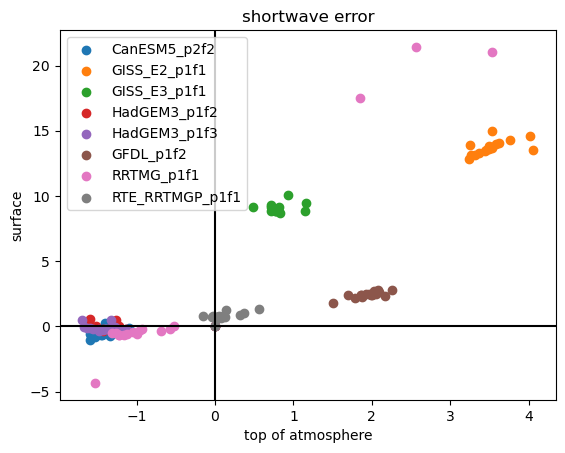

In [36]:
fig, ax = plt.subplots()
for m in list(gbmforcing.keys()):
    plt.scatter(gbmforcing[m][0,:,0],gbmforcing[m][0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbmf.keys()))
plt.title("shortwave error")
plt.show()

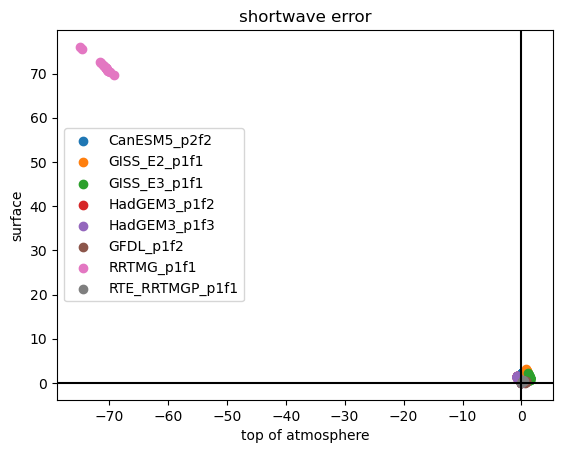

In [37]:
fig, ax = plt.subplots()
for m in list(gbmforcing.keys()):
    plt.scatter(gbmforcing[m][1,:,0],gbmforcing[m][1,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbmf.keys()))
plt.title("shortwave error")
plt.show()